In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install keras-unet-collection
! pip install segmentation-models

     |████████████████████████████████| 67 kB 842 kB/s eta 0:00:01
     |████████████████████████████████| 50 kB 1.9 MB/s eta 0:00:01


In [4]:
# required libraries 
import numpy as np 
import pandas as pd
import os
from pathlib import Path
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing

from keras_unet_collection import models,losses

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [5]:
train_df = pd.read_csv('../input/sartorius-cell-instance-segmentation/train.csv')
print(train_df.shape)
train_df.head(4)

(73585, 9)


,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


In [6]:
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)


def build_masks(labels,input_shape, colors=True):
    height, width = input_shape
    if colors:
        mask = np.zeros((height, width, 3))
        for label in labels:
            mask += rle_decode(label, shape=(height,width , 3), color=np.random.rand(3))
    else:
        mask = np.zeros((height, width, 1))
        for label in labels:
            mask += rle_decode(label, shape=(height, width, 1))
    mask = mask.clip(0, 1)
    return mask

def rle2maskResize(rle):
    # CONVERT RLE TO MASK 
    if (len(rle)==0): 
        return np.zeros((256,256) ,dtype=np.uint8)
    
    height= 520
    width = 704
    mask= np.zeros( width*height ,dtype=np.uint8)

    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]-1
    lengths = array[1::2]    
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
    
    return mask.reshape( (height,width), order='F' )[::2,::2]

(-0.5, 703.5, 519.5, -0.5)

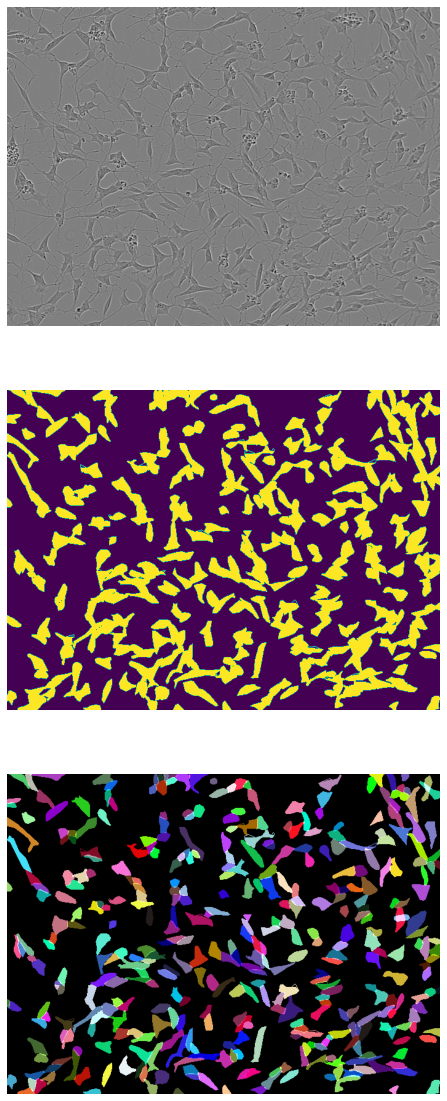

In [7]:
sample_filename = '0030fd0e6378'
sample_image_df = train_df[train_df['id'] == sample_filename]
sample_path = f"../input/sartorius-cell-instance-segmentation/train/{sample_image_df['id'].iloc[0]}.png"
sample_img = cv2.imread(sample_path)
sample_rles = sample_image_df['annotation'].values

sample_masks1=build_masks(sample_rles,input_shape=(520, 704), colors=False)
sample_masks2=build_masks(sample_rles,input_shape=(520, 704), colors=True)

fig, axs = plt.subplots(3, figsize=(20, 20))
axs[0].imshow(sample_img)
axs[0].axis('off')

axs[1].imshow(sample_masks1)
axs[1].axis('off')

axs[2].imshow(sample_masks2)
axs[2].axis('off')

In [11]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='../input/sartorius-cell-instance-segmentation/train',
                 batch_size=32, dim=(256, 256), n_channels=3,
                 n_classes=3, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['id'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}.png"
            img = self.__load_grayscale(img_path)
            
            
            # Store samples
            X[i,] = img 

        return X
    
    def __generate_y(self, list_IDs_batch):
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['id'].iloc[ID]
            image_df = self.target_df[self.target_df['id'] == im_name]
            
            rles = image_df['annotation'].values
            masks = build_masks(rles,(520,704), colors=False)
            masks = cv2.resize(masks, (256, 256))
            #masks=masks.transpose(1,0)
            masks=np.expand_dims(masks, axis=-1)
            y[i, ] = masks

        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        # resize image
        dsize = (256, 256)
        img = cv2.resize(img, dsize)
        
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img

In [12]:
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

In [13]:
BATCH_SIZE = 16

train_idx, val_idx = train_test_split(
    train_df.index, random_state=2019, test_size=0.2 # mask_count_df
)
train_generator = DataGenerator(
    train_idx, 
    df=train_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    n_classes=3
)
val_generator = DataGenerator(
    val_idx, 
    df=train_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    n_classes=3
)

### Defining model

In [ ]:
model1=models.att_unet_2d((256, 256, 3), [64, 128, 256, 512, 1024],n_labels=3,activation='ReLU',output_activation='Sigmoid',weights='imagenet',backbone='EfficientNetB0',batch_norm=True,freeze_backbone=True,pool=False,unpool=False,freeze_batch_norm=True)

### With Segmentation models library

In [14]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

'tf.keras'

In [15]:
from segmentation_models import Unet
from segmentation_models.utils import set_trainable


model = Unet('efficientnetb0',input_shape=(256, 256, 3), classes=3, activation='sigmoid',encoder_weights='imagenet')
#inp = Input(shape=(512, 640, 1))
#l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
#out = base_model(l1)
#model = Model(inp, out, name=base_model.name)

model.compile(optimizer='adam', loss=bce_jaccard_loss,metrics=[iou_score,'accuracy']) #bce_dice_loss binary_crossentropy


2021-11-26 13:19:39.409771: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-26 13:19:39.514072: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-26 13:19:39.514809: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-26 13:19:39.516123: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

16818176/16804768 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 128, 128, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 128, 128, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 128, 128, 32) 0           stem_bn[0][0]                    
_____________________________

In [ ]:
model1.compile(optimizer='adam', loss=bce_dice_loss,metrics=[dice_coef,iou_coef,'accuracy'])

In [16]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

In [ ]:

history = model1.fit(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint],
    use_multiprocessing=False,
    workers=4,
    epochs=10
)

### More Comming Soon..Please Upvote if you like it..